# Typical Section Aeroelasticity

In [1]:
# Enable interactive plots in JupyterLab
%matplotlib widget

# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as wgt
import numpy as np
import math
from IPython.display import display, Markdown
import textwrap

# This acts like a function allowing the creation of "struct-like" objects
class defineStruct:
    pass

# Import NACA0012 profile coordinates (suction side only)
airfoilData = pd.read_csv('NACA0012_suctionSide.csv').to_numpy(dtype = float)

## The Typical Section

In [2]:
# Generate the plot
plt.ioff()
fig, ax = plt.subplots(figsize = (8, 4));
ax.axis("equal"); ax.axis("off");

# Plot skins
ax.plot(airfoilData[:, 0], airfoilData[:, 1], color = 'black'); # suction side skin
ax.plot(airfoilData[:, 0], -airfoilData[:, 1], color = 'black'); # pressure side skin

# Plot auxiliary lines
# plt.plot(np.array([0, 0]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5) # leading edge line
# plt.plot(np.array([1, 1]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5) # trailing edge line
ax.plot(np.array([0.5, 0.5]), 0.3*np.array([1, -1]), color = 'black', linewidth = 0.5, linestyle = '--'); # mid-chord line

# Plot aerodynamic centre
ax.plot(0.25*np.array([1, 1]), 0.10*np.array([0, 1]), color = 'black', linewidth = 0.5);
p_ac = ax.scatter(0.25, 0, s = 40, c = 'black', marker = 'x');
ax.plot(np.array([0.25, 0.5]), 0.09*np.array([1, 1]), color = 'black', linewidth = 0.5);
ax.text(3*0.25/2, 0.11, str(f"{-2*0.25:.2f}"), ha = 'center', va = 'center');

In [3]:
# Set initial values, to get default graph
a = -0.2; cg_a = 0.15; c =  0.4; cg_f = 0.55;

x_th = cg_a - a; x_b = cg_f - c;

def getFlapData(c):

    # Distance between hinge line and points on the skin
    hingeDist = airfoilData - np.array([c/2 + 0.5, 0]) # distance vectors
    hingeDist = np.linalg.norm(hingeDist, axis = 1) # distance magnitude
    
    ind_minDist = np.argmin(hingeDist) # index of nearest skin point
    minDist = hingeDist[ind_minDist] # distance to nearest skin point
    minPoint = airfoilData[ind_minDist, :] # nearest point coordinates
    
    # Get circle segment representing the front end of the flap
    segAng = np.pi - math.atan2(minPoint[1], minPoint[0] - (c/2 + 0.5)) # angle between negative x-axis and nearest skin point
    arr_segAng = np.linspace(0, segAng, 20).reshape(20, 1)
    
    x_frontFlap = -minDist*np.cos(arr_segAng) + (c/2 + 0.5)
    y_frontFlap = minDist*np.sin(arr_segAng)
    
    frontFlapData = np.hstack((np.vstack((x_frontFlap[::-1], x_frontFlap[1:])),
                               np.vstack((-y_frontFlap[::-1], y_frontFlap[1:]))))

    return frontFlapData

# Plot flap
frontFlapData = getFlapData(c)
line_flap, = ax.plot(frontFlapData[:, 0], frontFlapData[:, 1], color = 'black');

In [4]:
# Elastic axis
vLine_a, = ax.plot((a/2 + 0.5)*np.array([1, 1]), 0.16*np.array([0, 1]), color = 'blue', linewidth = 0.5);
p_a = ax.scatter(a/2 + 0.5, 0, s = 40, c = 'blue', marker = 'o', edgecolor = 'black');
hLine_a, = ax.plot(np.array([a/2 + 0.5, 0.5]), 0.15*np.array([1, 1]), color = 'blue', linewidth = 0.5);
txt_a = ax.text(0.5 + a/4, 0.17, str(f"{a:.2f}"), ha = 'center', va = 'center', color = 'blue');

# Centre of gravity - airfoil
vLine_CGa, = ax.plot((cg_a/2 + 0.5)*np.array([1, 1]), 0.22*np.array([0, 1]), color = 'blue', linewidth = 0.5);
p_CGa = ax.scatter(cg_a/2 + 0.5, 0, s = 40, c = 'blue', marker = 'D', edgecolor = 'black');
hLine_CGa, = ax.plot(np.array([cg_a/2 + 0.5, 0.5]), 0.21*np.array([1, 1]), color = 'blue', linewidth = 0.5);
txt_CGa = ax.text(0.5 + cg_a/4, 0.23, str(f"{cg_a:.2f}"), ha = 'center', va = 'center', color = 'blue');

# x_theta
arr_xth = np.array([a/2 + 0.5, cg_a/2 + 0.5])
vLine_xth_a, =  ax.plot(arr_xth[0]*np.array([1, 1]), np.array([0.16, 0.28]), color = 'blue', linewidth = 0.5, linestyle = '--');
vLine_xth_CGa, =  ax.plot(arr_xth[1]*np.array([1, 1]), np.array([0.22, 0.28]), color = 'blue', linewidth = 0.5, linestyle = '--');
hLine_xth, = ax.plot(arr_xth, 0.27*np.array([1, 1]), color = 'blue', linewidth = 0.5, linestyle = '--');
txt_xth = ax.text(np.mean(arr_xth), 0.29, "$x_{\\theta}$ = " + f"{x_th:.2f}", ha = 'center', va = 'center', color = 'blue');

# Flap hinge axis
vLine_c, = ax.plot((c/2 + 0.5)*np.array([1, 1]), -0.16*np.array([0, 1]), color = 'red', linewidth = 0.5);
p_c = ax.scatter(c/2 + 0.5, 0, s = 40, c = 'red', marker = 'o', edgecolor = 'black');
hLine_c, = ax.plot(np.array([c/2 + 0.5, 0.5]), -0.15*np.array([1, 1]), color = 'red', linewidth = 0.5);
txt_c = ax.text(0.5 + c/4, -0.17, str(f"{c:.2f}"), ha = 'center', va = 'center', color = 'red');

# Centre of gravity - flap
vLine_CGf, = ax.plot((cg_f/2 + 0.5)*np.array([1, 1]), -0.22*np.array([0, 1]), color = 'red', linewidth = 0.5);
p_CGf = ax.scatter(cg_f/2 + 0.5, 0, s = 40, c = 'red', marker = 'D', edgecolor = 'black');
hLine_CGf, = ax.plot(np.array([cg_f/2 + 0.5, 0.5]), -0.21*np.array([1, 1]), color = 'red', linewidth = 0.5);
txt_CGf = ax.text(0.5 + cg_f/4, -0.23, str(f"{cg_f:.2f}"), ha = 'center', va = 'center', color = 'red');

# x_beta
arr_xb = np.array([c/2 + 0.5, cg_f/2 + 0.5])
vLine_xb_c, =  ax.plot(arr_xb[0]*np.array([1, 1]), -np.array([0.16, 0.28]), color = 'red', linewidth = 0.5, linestyle = '--');
vLine_xb_CGf, =  ax.plot(arr_xb[1]*np.array([1, 1]), -np.array([0.22, 0.28]), color = 'red', linewidth = 0.5, linestyle = '--');
hLine_xb, = ax.plot(arr_xb, -0.27*np.array([1, 1]), color = 'red', linewidth = 0.5, linestyle = '--');
txt_xb = ax.text(np.mean(arr_xb), -0.29, "$x_{\\beta}$ = " + f"{x_b:.2f}", ha = 'center', va = 'center', color = 'red');

ax.legend([p_ac, p_a, p_CGa, p_c, p_CGf], ["Aero. Centre", "Elastic Axis", "C.G. Airfoil", "Flap Hinge Axis", "C.G. Flap"],
           loc = 'center left', bbox_to_anchor = (1, 0.5));

In [5]:
def updatePoints(x, vLine, p, hLine, txt):

    # Start with vertical line
    vLine.set_xdata((x/2 + 0.5)*np.array([1, 1]))
    vLine.figure.canvas.draw_idle()

    # Update scatter point
    p.set_offsets(np.c_[x/2 + 0.5, 0])
    p.figure.canvas.draw_idle()

    # Update horizontal line
    hLine.set_xdata([x/2 + 0.5, 0.5])
    hLine.figure.canvas.draw_idle()

    # Finally update the text string as well as position
    txt.set_x(0.5 + x/4)
    txt.set_text(str(f"{x: .2f}"))
    txt.figure.canvas.draw_idle()

def updateDist(x1, x2, vLine_1, vLine_2, hLine, txt, str_symbol):

    arr_x = np.array([x1/2 + 0.5, x2/2 + 0.5])
    
    # Start with first vertical line, corresponding to ref point
    vLine_1.set_xdata(arr_x[0]*np.array([1, 1]))
    vLine_1.figure.canvas.draw_idle()

    # Then adapt the second vertical line, corresponding to CG point
    vLine_2.set_xdata(arr_x[1]*np.array([1, 1]))
    vLine_2.figure.canvas.draw_idle()

    # Update horizontal line
    hLine.set_xdata(arr_x)
    hLine.figure.canvas.draw_idle()

    # Finally update the text string as well as position
    x_dist = x2 - x1
    txt.set_x(np.mean(arr_x))
    txt.set_text(str_symbol + " = " + f"{x_dist:.2f}")
    txt.figure.canvas.draw_idle()
    

In [6]:
def updateTypSection(a, cg_a, c, cg_f):

    # Front flap line
    frontFlapData = getFlapData(c)
    line_flap.set_xdata(frontFlapData[:, 0])
    line_flap.set_ydata(frontFlapData[:, 1])
    line_flap.figure.canvas.draw_idle()

    # The four variable points
    updatePoints(a, vLine_a, p_a, hLine_a, txt_a) # elastic axis
    updatePoints(cg_a, vLine_CGa, p_CGa, hLine_CGa, txt_CGa) # C.G. airfoil
    updatePoints(c, vLine_c, p_c, hLine_c, txt_c) # hinged flap axis
    updatePoints(cg_f, vLine_CGf, p_CGf, hLine_CGf, txt_CGf) # C.G. flap

    # The two distances, x_theta and x_beta
    updateDist(a, cg_a, vLine_xth_a, vLine_xth_CGa, hLine_xth, txt_xth, "$x_{\\theta}$") # x_theta
    updateDist(c, cg_f, vLine_xb_c, vLine_xb_CGf, hLine_xb, txt_xb, "$x_{\\beta}$") # x_beta

def updateTypSection_v2(change):

    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value
    
    # Front flap line
    frontFlapData = getFlapData(c)
    line_flap.set_xdata(frontFlapData[:, 0])
    line_flap.set_ydata(frontFlapData[:, 1])
    line_flap.figure.canvas.draw_idle()

    # The four variable points
    updatePoints(a, vLine_a, p_a, hLine_a, txt_a) # elastic axis
    updatePoints(cg_a, vLine_CGa, p_CGa, hLine_CGa, txt_CGa) # C.G. airfoil
    updatePoints(c, vLine_c, p_c, hLine_c, txt_c) # hinged flap axis
    updatePoints(cg_f, vLine_CGf, p_CGf, hLine_CGf, txt_CGf) # C.G. flap

    # The two distances, x_theta and x_beta
    updateDist(a, cg_a, vLine_xth_a, vLine_xth_CGa, hLine_xth, txt_xth, "$x_{\\theta}$") # x_theta
    updateDist(c, cg_f, vLine_xb_c, vLine_xb_CGf, hLine_xb, txt_xb, "$x_{\\beta}$") # x_beta
    

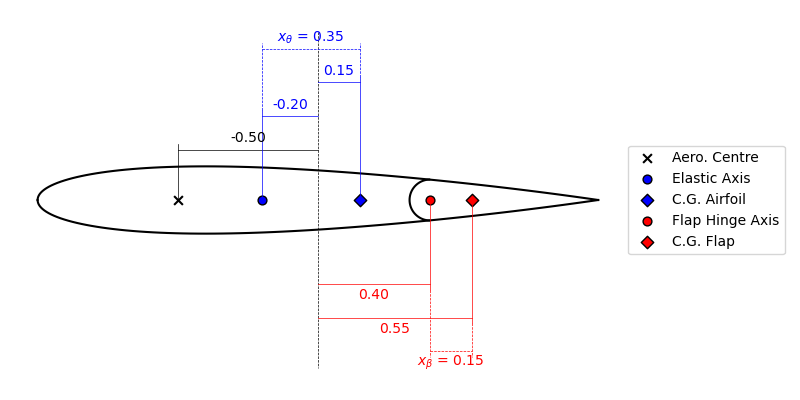

GridspecLayout(children=(FloatSlider(value=-0.2, description='Elastic Axis', layout=Layout(grid_area='widget00…

In [7]:
# Start by plotting graph
fig.tight_layout();
plt.show()

# Customise sliders
stepSize = 0.01
descrWidth = '120px'
sliderWidth = '450px'

# Define sliders
slider_a = wgt.FloatSlider(value = a, min = -0.9, max = 0.9, step = 0.01, 
                           description = 'Elastic Axis', style = {'description_width': descrWidth},
                           layout = wgt.Layout(width = sliderWidth))
slider_CGa = wgt.FloatSlider(value = cg_a, min = -0.9, max = 0.9, step = 0.01, 
                             description = 'C.G. Airfoil', style = {'description_width': descrWidth},
                             layout = wgt.Layout(width = sliderWidth))
slider_c = wgt.FloatSlider(value = c, min = -0.9, max = 0.9, step = 0.01,
                           description = 'Flap Hinge Axis', style = {'description_width': descrWidth},
                           layout = wgt.Layout(width = sliderWidth))
slider_CGf = wgt.FloatSlider(value = cg_f, min = -0.9, max = 0.9, step = 0.01, 
                             description = 'C.G. Flap', style = {'description_width': descrWidth},
                             layout = wgt.Layout(width = sliderWidth))

listSliders = [slider_a, slider_CGa, slider_c, slider_CGf]

# Link sliders with update function
for s in listSliders:
    s.observe(updateTypSection_v2, names = 'value')

# Display sliders in two columns
gridSliders = wgt.GridspecLayout(2, 2, layout = wgt.Layout(width = '1000px'))

gridSliders[0, 0] = slider_a
gridSliders[1, 0] = slider_CGa
gridSliders[0, 1] = slider_c
gridSliders[1, 1] = slider_CGf

display(gridSliders)

## Mass and Stiffness matrix

In [8]:
# Initialise the global variables
mat_strMass = None
mat_strStiff = None

# Define a function that takes the slider values and calculates the mass and stiffness matrix
def strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb):

    # Calculate key terms based on slider values
    x_th = cg_a - a
    x_b = cg_f - c

    m_tot = ma + mf
    S_th = (ma*x_th + mf*(c - a +x_b))*b
    S_b = mf*x_b*b

    Iaf_a = Iaf_CGa + ma*(x_th*b)**2 + mf*((c - a + x_b)*b)**2 # moment of inertia (airfoil + flap) wrt elastic axis - [kgm^2]
    If_f = If_CGf + mf*(x_b*b)**2

    # Assemble mass and stiffness matrices
    mat_strMass = np.array([[m_tot, S_th, S_b],
                            [S_th, Iaf_a, (c - a)*b*S_b + If_f],
                            [S_b, (c - a)*b*S_b + If_f, If_f]])
    mat_strStiff = np.array([[Kh, 0, 0],
                             [0, Kth, 0],
                             [0, 0, Kb]])

    return mat_strMass, mat_strStiff

# Define a function that rebuilds the matrices according to changing slider values and re-renders them as Markdown
def update_strMatrices(change = None):

    global mat_strMass, mat_strStiff
    
    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value

    b = slider_b.value

    Kh = slider_Kh.value
    Kth = slider_Kth.value
    Kb = slider_Kb.value

    ma = slider_ma.value
    mf = slider_mf.value

    Iaf_CGa = slider_Iaf.value
    If_CGf = slider_If.value

    # Calculate mass and stiffness matrix
    mat_strMass, mat_strStiff = strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb)

    # Write output into the Output widget
    with sliderOut:
        
        # Remove the previous matrix so outputs don't stack
        sliderOut.clear_output()
    
        # Display a Markdown cell containing LaTeX
        display(Markdown(textwrap.dedent(f"""
            $$
            \\text{{Mass matrix, }} \\overline{{\\overline{{M_s}}}} =
            \\begin{{bmatrix}}
            {mat_strMass[0, 0]:.2f} & {mat_strMass[0, 1]:.2f} & {mat_strMass[0, 2]:.2f} \\\\
            {mat_strMass[1, 0]:.2f} & {mat_strMass[1, 1]:.2f} & {mat_strMass[1, 2]:.2f} \\\\
            {mat_strMass[2, 0]:.2f} & {mat_strMass[2, 1]:.2f} & {mat_strMass[2, 2]:.2f}
            \\end{{bmatrix}}
            \\qquad
            \\text{{Stiffness matrix, }} \\overline{{\\overline{{K_s}}}} =
            \\begin{{bmatrix}}
            {mat_strStiff[0, 0]:.2f} & {mat_strStiff[0, 1]:.2f} & {mat_strStiff[0, 2]:.2f} \\\\
            {mat_strStiff[1, 0]:.2f} & {mat_strStiff[1, 1]:.2f} & {mat_strStiff[1, 2]:.2f} \\\\
            {mat_strStiff[2, 0]:.2f} & {mat_strStiff[2, 1]:.2f} & {mat_strStiff[2, 2]:.2f}
            \\end{{bmatrix}}
            $$
        """)))


In [9]:
# Define additional sliders. Remember, the typical section parameters defined above also affect the matrices!
slider_b = wgt.FloatSlider(value = 1.00, min = 0, max = 5, step = 0.1, 
                           style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                           description = 'Half-Chord') # half-chord length - [m]

slider_Kh = wgt.FloatSlider(value = 1.20, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = 'Stiff. Heave') # translational spring stiffness (heave) - [N/m]
slider_Kth = wgt.FloatSlider(value = 2.30, min = 0, max = 5, step = 0.1, 
                             style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                             description = 'Stiff. Pitch') # rotational spring stiffness (pitch) - [Nm/rad]
slider_Kb = wgt.FloatSlider(value = 5.00, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = 'Stiff. Flap Def.') # rotational spring stiffness (flap deflection) - [Nm/rad]

slider_ma = wgt.FloatSlider(value = 2.80, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = 'Mass Airfoil') # airfoil mass - [kg]
slider_mf = wgt.FloatSlider(value = 2.90, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = 'Mass Flap') # flap mass - [kg]

slider_Iaf = wgt.FloatSlider(value = 2.50, min = 0, max = 5, step = 0.1, 
                             style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                             description = 'Inertia Airfoil + Flap') # moment of inertia (airfoil + flap) wrt airfoil CG - [kgm^2]
slider_If = wgt.FloatSlider(value = 1.00, min = 0, max = 5, step = 0.1, 
                            style = {'description_width': descrWidth}, layout = wgt.Layout(width = sliderWidth),
                            description = 'Inertia Flap') # moment of inertia (flap) wrt flap CG - [kgm^2]

sliderOut = wgt.Output()
listSliders.extend([slider_b, slider_Kh, slider_Kth, slider_Kb, 
                    slider_ma, slider_mf, slider_Iaf, slider_If])



In [10]:
# Link sliders with update function
for s in listSliders:
    s.observe(update_strMatrices, names = 'value')

# Display sliders in two columns
gridSliders = wgt.GridspecLayout(5, 2, layout = wgt.Layout(width = '1000px'))

gridSliders[0, 0] = slider_b
gridSliders[1, 0] = slider_ma
gridSliders[2, 0] = slider_mf
gridSliders[3, 0] = slider_Iaf
gridSliders[4, 0] = slider_If

gridSliders[0, 1] = slider_Kh
gridSliders[1, 1] = slider_Kth
gridSliders[2, 1] = slider_Kb

display(gridSliders)
display(sliderOut)

# Initialise markdown cell with matrices
update_strMatrices()

GridspecLayout(children=(FloatSlider(value=1.0, description='Half-Chord', layout=Layout(grid_area='widget001',…

Output()

## Eigenvalue analysis

In [11]:
# Generate the plot
plt.ioff()
fig2, ax2 = plt.subplots(figsize = (8, 5));
ax2.axis("equal"); ax2.axis("off");

# Horizontal axis
fig2_dist = 0.25
ax2.plot(np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 1
ax2.plot(1 + fig2_dist + np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 2
ax2.plot(2*(1 + fig2_dist) + np.array([0, 1]), np.array([0, 0]), color = 'black', linewidth = 0.5, linestyle = '--'); # mode 3

# Headers
ax2.text(0.5, 1.2, "Mode 1", ha = 'center', va = 'center', color = 'black');
ax2.text(1 + fig2_dist + 0.5, 1.2, "Mode 2", ha = 'center', va = 'center', color = 'black');
ax2.text(2*(1 + fig2_dist) + 0.5, 1.2, "Mode 3", ha = 'center', va = 'center', color = 'black');

In [12]:
# Function that generates points along an arc
def calcArcPoints(p0, p1, p2, ang, n):

    # Unpack point coordinates
    cx, cy = p0 # center point
    x1, y1 = p1 # start point
    x2, y2 = p2 # end point

    # Check radii
    r1 = np.hypot(x1 - cx, y1 - cy)
    r2 = np.hypot(x2 - cx, y2 - cy)
    if not np.isclose(r1, r2):
        raise ValueError("Start and end points are not equidistant from the center")

    r = r1

    # Compute angles
    a1 = np.arctan2(y1 - cy, x1 - cx)
    a2 = np.arctan2(y2 - cy, x2 - cx)

    # Apply direction
    if ang >= 0:  # clockwise
        if a2 > a1:
            a2 -= 2 * np.pi
    else:         # counter-clockwise
        if a2 < a1:
            a2 += 2 * np.pi

    angles = np.linspace(a1, a2, n)

    x = cx + r * np.cos(angles)
    y = cy + r * np.sin(angles)

    return x, y

# Function that calculates all relevant geometry based on slider values and modeshape
def calcSectionPoints(a, c, vec_mode, x_offset):

    # Process a and c such that leading edge is at x = 0 and trailing edge is at x = 1
    x_a = 0.5 + a/2
    x_c = 0.5 + c/2
    
    # Process the modeshape for plotting
    normMode = vec_mode/np.max(np.abs(vec_mode))

    # Scale such that theta = 1 (or beta = 1) appears as 45 deg
    h = normMode[0]*np.pi/4
    theta = normMode[1]*np.pi/4 # rotational DoF maximise at 45 deg each
    beta = normMode[2]*np.pi/4

    # Calculate the x-y coordinates of the 1 + 6 key points on the typical section
    mat_sectionPoints = np.zeros((7, 2))
    mat_sectionPoints[0, :] = [x_a, 0] # elastic axis projected on the horizontal
    mat_sectionPoints[1, :] = [x_a, h] # elastic axis on the typical section
    mat_sectionPoints[2, :] = [0, h] # leading edge projection prior to theta rotation
   
    r3 = x_a
    mat_sectionPoints[3, 0] = -r3*np.cos(theta) + mat_sectionPoints[1, 0] # leading edge after theta rotation
    mat_sectionPoints[3, 1] = r3*np.sin(theta) + mat_sectionPoints[1, 1]

    r4 = x_c - x_a
    mat_sectionPoints[4, 0] = r4*np.cos(theta) + mat_sectionPoints[1, 0] # hinge point after theta rotation
    mat_sectionPoints[4, 1] = -r4*np.sin(theta) + mat_sectionPoints[1, 1]

    r5 = 1 - x_a
    mat_sectionPoints[5, 0] = r5*np.cos(theta) + mat_sectionPoints[1, 0] # trailing edge projection after theta rotation (no flap)
    mat_sectionPoints[5, 1] = -r5*np.sin(theta) + mat_sectionPoints[1, 1]

    r6 = 1 - x_c
    mat_sectionPoints[6, 0] = r6*np.cos(theta + beta) + mat_sectionPoints[4, 0] # trailing edge tip (on flap)
    mat_sectionPoints[6, 1] = -r6*np.sin(theta + beta) + mat_sectionPoints[4, 1]

    mat_sectionPoints[:, 0] = mat_sectionPoints[:, 0] + x_offset # translate along the horizontal
    
    return mat_sectionPoints

In [13]:
# Initial values to initialise the graph
a = slider_a.value
c = slider_c.value

arr_freq = np.array([1, 1, 1]) # vector of frequencies - [Hz]
mat_modeshapes = np.array([[1, 1, -1], 
                           [0.5, -0.5, -0.5],
                           [0.3, -0.3, 0.3]]) # matrix of modeshapes

structFigModes = defineStruct() # struct-like object with all plot objects for modeshape figure

structFigModes.mode1 = defineStruct()
structFigModes.mode1.freq = arr_freq[0]; structFigModes.mode1.mode = mat_modeshapes[:, 0]; structFigModes.mode1.x_off = 0;

structFigModes.mode2 = defineStruct()
structFigModes.mode2.freq = arr_freq[1]; structFigModes.mode2.mode = mat_modeshapes[:, 1]; structFigModes.mode2.x_off = 1 + fig2_dist;

structFigModes.mode3 = defineStruct()
structFigModes.mode3.freq = arr_freq[2]; structFigModes.mode3.mode = mat_modeshapes[:, 2]; structFigModes.mode3.x_off = 2*(1 + fig2_dist);

# Initialise graph one mode at a time
for s in (structFigModes.mode1, structFigModes.mode2, structFigModes.mode3):

    # Calculate key typical section points
    secPoints = calcSectionPoints(a, c, s.mode, s.x_off)

    # Define main line objects
    s.line1, = ax2.plot(secPoints[[3, 4], 0], secPoints[[3, 4], 1], color = 'black', linewidth = 1);
    s.line2, = ax2.plot(secPoints[[4, 6], 0], secPoints[[4, 6], 1], color = 'black', linewidth = 1);

    s.line3, = ax2.plot(secPoints[[1, 2], 0], secPoints[[1, 2], 1], color = 'blue', linewidth = 0.5, linestyle = '--');
    s.line4, = ax2.plot(secPoints[[4, 5], 0], secPoints[[4, 5], 1], color = 'red', linewidth = 0.5, linestyle = '--');

    s.point5 = ax2.scatter(secPoints[1, 0], secPoints[1, 1], s = 40, c = 'blue', marker = 'o', edgecolor = 'black');
    s.point6 = ax2.scatter(secPoints[4, 0], secPoints[4, 1], s = 40, c = 'red', marker = 'o', edgecolor = 'black');

    s.line7, = ax2.plot(secPoints[[0, 1], 0], secPoints[[0, 1], 1], color = 'blue', linewidth = 1);

    # Get arcs for rotational DoF
    x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :], s.mode[1], n = 20) # theta
    s.line8, = ax2.plot(x_arc1, y_arc1, color = 'blue', linewidth = 1);

    x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :], s.mode[2], n = 20) # beta
    s.line9, = ax2.plot(x_arc2, y_arc2, color = 'red', linewidth = 1);

    # Get text displaying the frequency value and modeshape vector
    s.txt10 = ax2.text(s.x_off + 0.5, 1.1, "f = " + f"{s.freq:.2f}" + "Hz", ha = 'center', va = 'center', color = 'black');

    normMode = s.mode/np.max(np.abs(s.mode))
    str_modeshape = "$\\vec{\\phi} = [$" + f"{normMode[0]:.2f}" + ", " + f"{normMode[1]:.2f}" + ", " + f"{normMode[2]:.2f}" + "$]^{T}$"
    s.txt11 = ax2.text(s.x_off + 0.5, 1.0, str_modeshape, ha = 'center', va = 'center', color = 'black');


In [14]:
# Function that updates the modes graph
def updateModeGraph(change):

    # Adapt variables based on sliders
    a = slider_a.value
    cg_a = slider_CGa.value
    c = slider_c.value
    cg_f = slider_CGf.value

    b = slider_b.value

    Kh = slider_Kh.value
    Kth = slider_Kth.value
    Kb = slider_Kb.value

    ma = slider_ma.value
    mf = slider_mf.value

    Iaf_CGa = slider_Iaf.value
    If_CGf = slider_If.value

    # Recalculate mass and stiffness matrices - simpler than importing them dynamically
    mat_strMass, mat_strStiff = strMatrices(a, cg_a, c, cg_f, b, ma, mf, Iaf_CGa, If_CGf, Kh, Kth, Kb)

    # Perform eigenvalue analysis
    mat_A = np.dot(np.linalg.inv(mat_strMass), mat_strStiff) # matrix product inv(M)*K
    eigVals, eigVecs = np.linalg.eig(mat_A)

    # Sort from lowest to highest frequency
    indSort = np.argsort(eigVals)

    arr_freq = np.sqrt(eigVals[indSort])/(2*np.pi)
    mat_modeshapes = eigVecs[:, indSort]

    # Update struct before for-loop
    structFigModes.mode1.freq = arr_freq[0]; structFigModes.mode1.mode = mat_modeshapes[:, 0];
    structFigModes.mode2.freq = arr_freq[1]; structFigModes.mode2.mode = mat_modeshapes[:, 1];
    structFigModes.mode3.freq = arr_freq[2]; structFigModes.mode3.mode = mat_modeshapes[:, 2];

    for stru in (structFigModes.mode1, structFigModes.mode2, structFigModes.mode3):

        # Calculate key typical section points
        secPoints = calcSectionPoints(a, c, stru.mode, stru.x_off)
    
        # Update plot objects accordingly
        stru.line1.set_xdata(secPoints[[3, 4], 0]); stru.line1.set_ydata(secPoints[[3, 4], 1]);
        stru.line1.figure.canvas.draw_idle()
        
        stru.line2.set_xdata(secPoints[[4, 6], 0]); stru.line2.set_ydata(secPoints[[4, 6], 1]);
        stru.line2.figure.canvas.draw_idle()

        stru.line3.set_xdata(secPoints[[1, 2], 0]); stru.line3.set_ydata(secPoints[[1, 2], 1]);
        stru.line3.figure.canvas.draw_idle()

        stru.line4.set_xdata(secPoints[[4, 5], 0]); stru.line4.set_ydata(secPoints[[4, 5], 1]);
        stru.line4.figure.canvas.draw_idle()

        # p.set_offsets(np.c_[x/2 + 0.5, 0])
        # p.figure.canvas.draw_idle()

        stru.point5.set_offsets(np.c_[secPoints[1, 0], secPoints[1, 1]])
        stru.point5.figure.canvas.draw_idle()
     
        stru.point6.set_offsets(np.c_[secPoints[4, 0], secPoints[4, 1]])
        stru.point6.figure.canvas.draw_idle()

        stru.line7.set_xdata(secPoints[[0, 1], 0]); stru.line7.set_ydata(secPoints[[0, 1], 1]);
        stru.line7.figure.canvas.draw_idle()
    
        # Get arcs for rotational DoF
        x_arc1, y_arc1 = calcArcPoints(secPoints[1, :], secPoints[2, :], secPoints[3, :], stru.mode[1], n = 20) # theta
        stru.line8.set_xdata(x_arc1); stru.line8.set_ydata(y_arc1);
        stru.line8.figure.canvas.draw_idle()
    
        x_arc2, y_arc2 = calcArcPoints(secPoints[4, :], secPoints[5, :], secPoints[6, :], stru.mode[2], n = 20) # beta
        stru.line9.set_xdata(x_arc2); stru.line9.set_ydata(y_arc2);
        stru.line9.figure.canvas.draw_idle()
    
        # Get text displaying the frequency value and modeshape vector
        stru.txt10.set_text("f = " + f"{stru.freq:.2f}" + "Hz")
        stru.txt10.figure.canvas.draw_idle()
    
        # normMode = stru.mode/np.linalg.norm(stru.mode)
        normMode = stru.mode/np.max(np.abs(stru.mode))
        stru.txt11.set_text("$\\vec{\\phi} = [$" + f"{normMode[0]:.2f}" + ", " + f"{normMode[1]:.2f}" + ", " + f"{normMode[2]:.2f}" + "$]^{T}$")
        # stru.txt11.set_text("f = " + f"{stru.freq:.2f}" + "Hz")
        stru.txt11.figure.canvas.draw_idle()


    # txt.set_text(str(f"{x: .2f}"))
    # txt.figure.canvas.draw_idle()

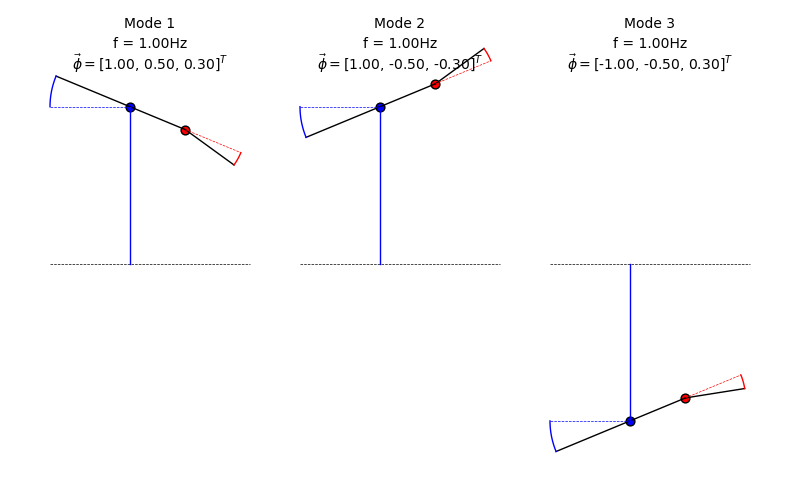

In [15]:
# Start by plotting graph
fig2.tight_layout();
plt.show()

# Link sliders with update function
for s in listSliders:
    s.observe(updateModeGraph, names = 'value')